In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

Using TensorFlow backend.


In [3]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
pathds = '/home/user/01Code/00Datasets_final/'

In [6]:
#df_chunk = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv', chunksize=1000)
#df = df_chunk.get_chunk(300000)
df = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID20bal_stdscal.csv')

In [7]:
df.shape

(504576, 67)

#### 4.2 Explaining the data

In [8]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 252288
Class 1: 252288
Proportion: 1.0 : 1


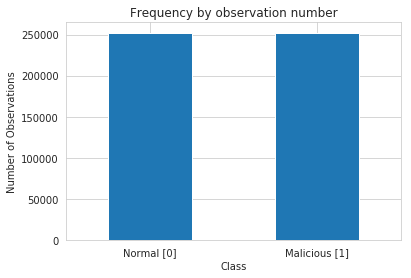

In [9]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [10]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [11]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [12]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [13]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, 66].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, 66].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, 66].sum()/test_df.shape[0])

0.5015514294207997
0.4981915473418223
0.4964822228387966


In [14]:
train_x = train_df.iloc[:, :66] 
dev_x = dev_df.iloc[:, :66] 
test_x = test_df.iloc[:, :66] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [15]:
# Define the final train and test sets
train_y = train_df.iloc[:,66]
dev_y = dev_df.iloc[:,66]
test_y = test_df.iloc[:,66]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [16]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

66


### Autoencoder Function

encoding_dim - 2

Epoch 94/300 78596/78596 [==============================] - 10s 125us/step 
- loss: 3.8990e-05 - acc: 0.0237 - 
        val_loss: 3.9704e-05 - val_acc: 0.0236

In [17]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [18]:
def sae(factor_enc_dim, output_activation,
        optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activation='relu', name='input_layer')(input_data)
    encoded = Dense(int(encoding_dim/2), activation='relu')(encoded) ##Stacked AE
    encoded_bottle_neck = Dense(int(encoding_dim/4), activation='relu', name='enc_bottle_neck')(encoded) ##Stacked AE
    
    ### Define decoding layer
    decoded = Dense(int(encoding_dim/2), activation='relu')(encoded_bottle_neck) ##Stacked AE
    decoded = Dense(encoding_dim, activation='relu')(decoded) ##Stacked AE
    decoded = Dense(train_x.shape[1], activation=output_activation)(decoded)
    
    ### Create the autoencoder model
    sae = Model(input_data, decoded)
    sae.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    
    print(sae.summary())

    encoder = Model(input_data, encoded_bottle_neck)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return sae,encoded_train_x,encoded_test_x

In [19]:
def spae(factor_enc_dim, output_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation='relu', name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=output_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [20]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=1,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    elapsed_time = (time.time() - start_time)
    print("--- AE spent %s seconds ---" % elapsed_time)
    
    return hist_auto

In [21]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Autoencoder model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [22]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(50, activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(34, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [23]:
def ann_2h_(neurons,encoded_train_x,init_mode,activation_input,
               dropout_rate,activation_output,
               loss,lr):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(50, activation="relu")) #rezvy

    model.add(Dense(34, activation="relu")) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

    optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [24]:
def ann_2h__(neurons,encoded_train_x,activation_input,
             activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(50, activation="relu")) #rezvy

    model.add(Dense(34, activation="relu")) #rezvy
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

#     optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [25]:
def ann_1h_36n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(50, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [26]:
def ann_1h_24n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(50, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [27]:
def ann_1h_24n_(neurons,encoded_train_x,activation_input,
               activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(50, activation="relu")) #rezvy
    
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [28]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=1)

    elapsed_time = (time.time() - start_time)
    print("--- ANN spent %s seconds ---" % elapsed_time)

    return history

In [123]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob, pred_ann_01

In [30]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()
    

loss: 2.7516e-05 - acc: 0.0407 

val_loss: 2.7072e-05 - val_acc: 0.0399

In [126]:
ae_sigmoid_adam_logcosh,enc_train_x_asal,enc_test_x_asal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'relu',
                                                              dec_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 66)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 44)                2948      
_________________________________________________________________
dense_49 (Dense)             (None, 66)                2970      
Total params: 5,918
Trainable params: 5,918
Non-trainable params: 0
_________________________________________________________________
None


In [127]:
#ae_sigmoid_adam_logcosh = load_model('ae_sigmoid_adam_logcosh_redds10bal.h5')

In [128]:
hist_ae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "ae_sigmoid_adam_logcosh_redds20bal.h5",
                                        autoencoder = ae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 66, 
                                        shuffle = False)

Tue Jun 11 15:45:03 2019
Train on 322928 samples, validate on 80732 samples
Epoch 1/200
322928/322928 [==============================] - 14s 44us/step - loss: 0.0575 - acc: 0.1564 - val_loss: 0.0523 - val_acc: 0.1469
Epoch 2/200
322928/322928 [==============================] - 11s 35us/step - loss: 0.0522 - acc: 0.1326 - val_loss: 0.0521 - val_acc: 0.1006
Epoch 3/200
 40392/322928 [==>...........................] - ETA: 9s - loss: 0.0522 - acc: 0.0964

KeyboardInterrupt: 

In [ ]:
best_loss_value_ae_sigmoid_adam_logcosh = plot_hist_auto(hist_ae_sigmoid_adam_logcosh, './Figures/ae_sigmoid_adam_logcosh.png')

In [ ]:
ae_siglin_adam_logcosh,enc_train_x_aslal,enc_test_x_aslal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'sigmoid',
                                                              dec_activation = 'linear',
                                                              optimizer='Adam',
                                                              loss='logcosh')

In [ ]:
#ae_siglin_adam_logcosh = load_model('ae_siglin_adam_logcosh_redds10bal.h5')

In [ ]:
hist_ae_siglin_adam_logcosh = fit_ae(checkpoint_file = "ae_siglin_adam_logcosh_redds20bal.h5",
                                        autoencoder = ae_siglin_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 66, 
                                        shuffle = False)

In [ ]:
best_loss_value_ae_siglin_adam_logcosh = plot_hist_auto(hist_ae_siglin_adam_logcosh, './Figures/hist_ae_siglin_adam_logcosh.png')

In [ ]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

In [ ]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [ ]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "ae_sigmoid_adam_mse_redds20bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = 66,
                                  shuffle = False)

Best loss value: 0.15528448822173077


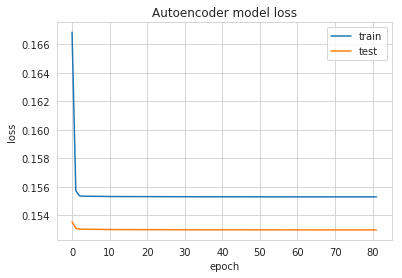

In [42]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

In [43]:
ae_sigsig_adam_logcosh,enc_train_x_assal,enc_test_x_assal = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'sigmoid',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 66)                0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 44)                2948      
_________________________________________________________________
dense_4 (Dense)              (None, 66)                2970      
Total params: 5,918
Trainable params: 5,918
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
#ae_sigsig_adam_logcosh = load_model('ae_sigsig_adam_logcosh_redds10bal.h5')

In [45]:
hist_ae_sigsig_adam_logcosh = fit_ae(checkpoint_file = "ae_sigsig_adam_logcosh_redds20bal.h5",
                                  autoencoder = ae_sigsig_adam_logcosh, 
                                  epochs = 200, 
                                  batch_size = 66,
                                  shuffle = False)

Sun Jun  9 17:09:33 2019
Train on 322928 samples, validate on 80732 samples
Epoch 1/200
322928/322928 [==============================] - 10s 30us/step - loss: 0.0665 - acc: 0.2593 - val_loss: 0.0563 - val_acc: 0.3233
Epoch 2/200
322928/322928 [==============================] - 10s 30us/step - loss: 0.0539 - acc: 0.3175 - val_loss: 0.0525 - val_acc: 0.2960
Epoch 3/200
322928/322928 [==============================] - 10s 30us/step - loss: 0.0524 - acc: 0.2714 - val_loss: 0.0522 - val_acc: 0.2356
Epoch 4/200
322928/322928 [==============================] - 10s 30us/step - loss: 0.0522 - acc: 0.2033 - val_loss: 0.0521 - val_acc: 0.1740
Epoch 5/200
322928/322928 [==============================] - 10s 30us/step - loss: 0.0522 - acc: 0.1547 - val_loss: 0.0521 - val_acc: 0.1447
Epoch 6/200
322928/322928 [==============================] - 9s 29us/step - loss: 0.0522 - acc: 0.1415 - val_loss: 0.0521 - val_acc: 0.1457
Epoch 7/200
322928/322928 [==============================] - 9s 29us/step - los

Best loss value: 0.05208804453885328


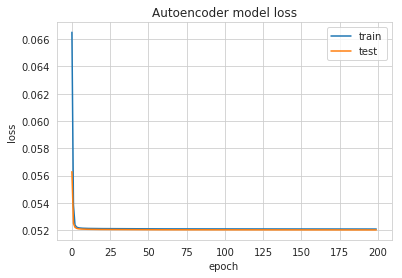

In [46]:
best_loss_value_ae_sigsig_adam_logcosh  = plot_hist_auto(hist_ae_sigsig_adam_logcosh, './Figures/hist_ae_sigsig_adam_logcosh.png')

In [47]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_logcosh': best_loss_value_ae_sigmoid_adam_logcosh,
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_ae_siglin_adam_logcosh': best_loss_value_ae_siglin_adam_logcosh,
    'loss_value_ae_sigsig_adam_logcosh': best_loss_value_ae_sigsig_adam_logcosh
    }

In [48]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_logcosh': 0.05211055273531513,
 'loss_value_ae_sigmoid_adam_mse': 0.15528448822173077,
 'loss_value_ae_siglin_adam_logcosh': 0.0007420364132673449,
 'loss_value_ae_sigsig_adam_logcosh': 0.05208804453885328}

In [129]:
print(enc_train_x_asal.shape)
print(enc_test_x_asal.shape)

print(enc_train_x_asam.shape)
print(enc_test_x_asam.shape)

print(enc_train_x_aslal.shape)
print(enc_test_x_aslal.shape)

print(enc_train_x_assal.shape)
print(enc_test_x_assal.shape)

(322928, 44)
(100916, 44)
(322928, 44)
(100916, 44)
(322928, 44)
(100916, 44)
(322928, 44)
(100916, 44)


#### ====================== Fail ANN ======================

In [50]:
ann36n_unisoftsigbinlosadam = ann_1h_36n(neurons=66,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 66)                2970      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                3350      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 6,571
Trainable params: 6,471
Non-trainable params: 100
_________________________________________________________________
None


In [51]:
hist_ann36n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam_redds20bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 66)

Sun Jun  9 17:38:22 2019
Train on 258342 samples, validate on 64586 samples
Epoch 1/200
258342/258342 [==============================] - 13s 49us/step - loss: 0.3337 - acc: 0.8517 - val_loss: 0.2142 - val_acc: 0.9109
Epoch 2/200
258342/258342 [==============================] - 12s 47us/step - loss: 0.1977 - acc: 0.9170 - val_loss: 0.1672 - val_acc: 0.9280
Epoch 3/200
258342/258342 [==============================] - 12s 47us/step - loss: 0.1688 - acc: 0.9288 - val_loss: 0.1763 - val_acc: 0.9230
Epoch 4/200
258342/258342 [==============================] - 12s 47us/step - loss: 0.1499 - acc: 0.9365 - val_loss: 0.1264 - val_acc: 0.9436
Epoch 5/200
258342/258342 [==============================] - 12s 47us/step - loss: 0.1384 - acc: 0.9412 - val_loss: 0.1263 - val_acc: 0.9476
Epoch 6/200
258342/258342 [==============================] - 12s 47us/step - loss: 0.1276 - acc: 0.9446 - val_loss: 0.1211 - val_acc: 0.9505
Epoch 7/200
258342/258342 [==============================] - 12s 47us/step - l

Best loss value: 0.056647425761245006


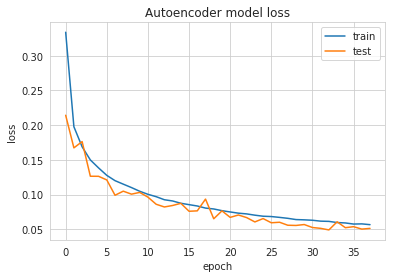

In [52]:
best_loss_value_ann36n_unisoftsigbinlosadam = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam, './Figures/ann36_unisoftsigbinlosadam.png')

In [130]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam = ann_predict(ann36n_unisoftsigbinlosadam,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.5011791985413612
              precision    recall  f1-score   support

           0     0.5035    0.6791    0.5782     50813
           1     0.4964    0.3207    0.3896     50103

   micro avg     0.5012    0.5012    0.5012    100916
   macro avg     0.4999    0.4999    0.4839    100916
weighted avg     0.4999    0.5012    0.4846    100916



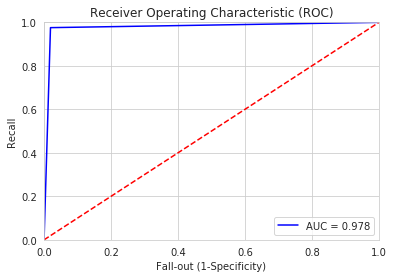

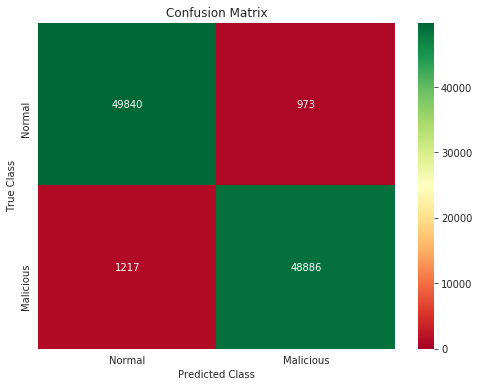

In [54]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [55]:
ann36n_unisoftsigbinlosadam2 = ann_1h_36n(neurons=66,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 66)                2970      
_________________________________________________________________
dense_9 (Dense)              (None, 50)                3350      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 6,571
Trainable params: 6,471
Non-trainable params: 100
_________________________________________________________________
None


In [56]:
hist_ann36n_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam2_redds20bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 66)

Sun Jun  9 17:46:08 2019
Train on 258342 samples, validate on 64586 samples
Epoch 1/200
258342/258342 [==============================] - 14s 56us/step - loss: 0.3320 - acc: 0.8542 - val_loss: 0.2301 - val_acc: 0.9169
Epoch 2/200
258342/258342 [==============================] - 14s 54us/step - loss: 0.1904 - acc: 0.9238 - val_loss: 0.1797 - val_acc: 0.9255
Epoch 3/200
258342/258342 [==============================] - 14s 54us/step - loss: 0.1574 - acc: 0.9352 - val_loss: 0.1347 - val_acc: 0.9447
Epoch 4/200
258342/258342 [==============================] - 14s 54us/step - loss: 0.1400 - acc: 0.9415 - val_loss: 0.1276 - val_acc: 0.9510
Epoch 5/200
258342/258342 [==============================] - 14s 54us/step - loss: 0.1289 - acc: 0.9462 - val_loss: 0.1274 - val_acc: 0.9483
Epoch 6/200
258342/258342 [==============================] - 14s 54us/step - loss: 0.1193 - acc: 0.9492 - val_loss: 0.1037 - val_acc: 0.9588
Epoch 7/200
258342/258342 [==============================] - 14s 53us/step - l

Best loss value: 0.04343031212755191


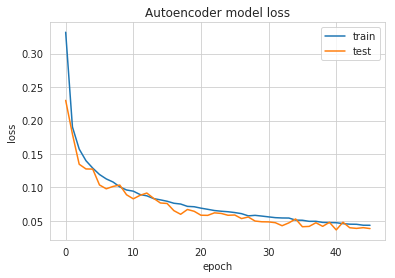

In [57]:
best_loss_value_ann36n_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam2, './Figures/ann36_unisoftsigbinlosadam2.png')

In [125]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam2 = ann_predict(ann36n_unisoftsigbinlosadam2,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9836101311982243
              precision    recall  f1-score   support

           0     0.9802    0.9874    0.9838     50813
           1     0.9871    0.9798    0.9834     50103

   micro avg     0.9836    0.9836    0.9836    100916
   macro avg     0.9837    0.9836    0.9836    100916
weighted avg     0.9836    0.9836    0.9836    100916



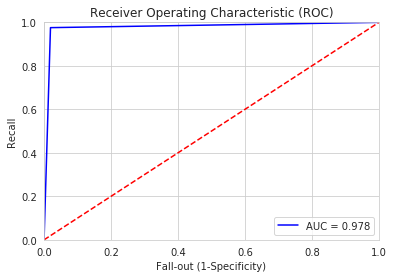

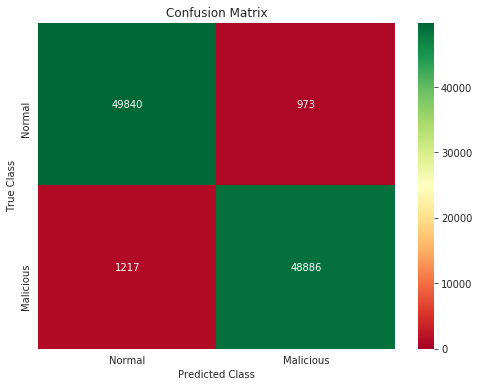

In [59]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [65]:
ann_2h_unisoftsigbinlosadam = ann_2h(neurons=66,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 66)                2970      
_________________________________________________________________
dense_15 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_16 (Dense)             (None, 34)                1734      
_________________________________________________________________
batch_normalization_4 (Batch (None, 34)                136       
_________________________________________________________________
dropout_4 (Dropout)          (None, 34)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 35        
Total params: 8,225
Trainable params: 8,157
Non-trainable params: 68
_________________________________________________________________
None


In [66]:
hist_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam_redds20bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 66)

Sun Jun  9 18:04:59 2019
Train on 258342 samples, validate on 64586 samples
Epoch 1/200
258342/258342 [==============================] - 16s 63us/step - loss: 0.3004 - acc: 0.8613 - val_loss: 0.1651 - val_acc: 0.9338
Epoch 2/200
258342/258342 [==============================] - 16s 60us/step - loss: 0.1453 - acc: 0.9382 - val_loss: 0.1356 - val_acc: 0.9434
Epoch 3/200
258342/258342 [==============================] - 15s 60us/step - loss: 0.1147 - acc: 0.9513 - val_loss: 0.1009 - val_acc: 0.9579
Epoch 4/200
258342/258342 [==============================] - 16s 60us/step - loss: 0.0994 - acc: 0.9575 - val_loss: 0.0796 - val_acc: 0.9632
Epoch 5/200
258342/258342 [==============================] - 15s 60us/step - loss: 0.0894 - acc: 0.9616 - val_loss: 0.0757 - val_acc: 0.9679
Epoch 6/200
258342/258342 [==============================] - 15s 59us/step - loss: 0.0823 - acc: 0.9646 - val_loss: 0.0820 - val_acc: 0.9639
Epoch 7/200
258342/258342 [==============================] - 15s 59us/step - l

In [67]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.02233836304477448


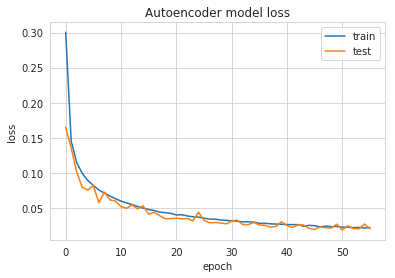

In [68]:
best_loss_value_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam, './Figures/ann_2h_unisoftsigbinlosadam.png')

In [124]:
pred_ann_2h_prob_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam = ann_predict(ann_2h_unisoftsigbinlosadam,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9916068809703119
              precision    recall  f1-score   support

           0     0.9956    0.9877    0.9916     50813
           1     0.9876    0.9956    0.9916     50103

   micro avg     0.9916    0.9916    0.9916    100916
   macro avg     0.9916    0.9916    0.9916    100916
weighted avg     0.9916    0.9916    0.9916    100916



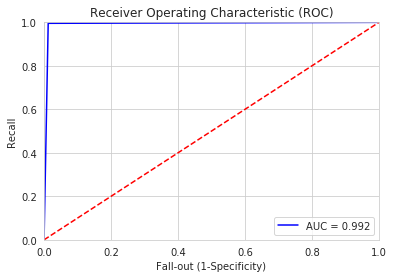

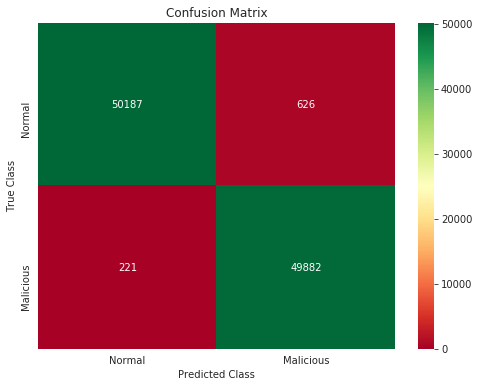

In [70]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ann_2h_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam_redds10bal.png')

In [71]:
ann_2h_unisoftsigbinlosadam2 = ann_2h_(neurons=66,
                                      encoded_train_x=enc_train_x_asal,
#                                       init_mode='glorot_uniform',
                                       init_mode='VarianceScaling',
#                                       activation_input='softsign',
                                      activation_input='relu',
#                                       weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      lr=0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 66)                2970      
_________________________________________________________________
dense_19 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_20 (Dense)             (None, 34)                1734      
_________________________________________________________________
batch_normalization_5 (Batch (None, 34)                136       
_________________________________________________________________
dropout_5 (Dropout)          (None, 34)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 35        
Total params: 8,225
Trainable params: 8,157
Non-trainable params: 68
_________________________________________________________________
None


In [72]:
hist_ann_2h_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam2_redds20bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 66)

Sun Jun  9 18:18:34 2019
Train on 258342 samples, validate on 64586 samples
Epoch 1/200
258342/258342 [==============================] - 16s 62us/step - loss: 0.3307 - acc: 0.8452 - val_loss: 0.2036 - val_acc: 0.9189
Epoch 2/200
258342/258342 [==============================] - 15s 59us/step - loss: 0.1917 - acc: 0.9174 - val_loss: 0.3866 - val_acc: 0.8756
Epoch 3/200
258342/258342 [==============================] - 15s 59us/step - loss: 0.1552 - acc: 0.9329 - val_loss: 0.1216 - val_acc: 0.9477
Epoch 4/200
258342/258342 [==============================] - 15s 58us/step - loss: 0.1343 - acc: 0.9427 - val_loss: 0.1168 - val_acc: 0.9487
Epoch 5/200
258342/258342 [==============================] - 15s 59us/step - loss: 0.1195 - acc: 0.9488 - val_loss: 0.1500 - val_acc: 0.9331
Epoch 6/200
258342/258342 [==============================] - 15s 59us/step - loss: 0.1123 - acc: 0.9529 - val_loss: 0.1045 - val_acc: 0.9577
Epoch 7/200
258342/258342 [==============================] - 15s 58us/step - l

Best loss value: 0.06010033188310186


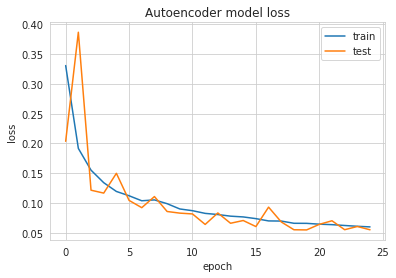

In [73]:
best_loss_value_ann_2h_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam2, './Figures/ann_2h_unisoftsigbinlosadam2.png')

In [132]:
pred_ann_2h_prob_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2 = ann_predict(ann_2h_unisoftsigbinlosadam2,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.4792897062903801
              precision    recall  f1-score   support

           0     0.4878    0.6831    0.5692     50813
           1     0.4589    0.2726    0.3420     50103

   micro avg     0.4793    0.4793    0.4793    100916
   macro avg     0.4734    0.4778    0.4556    100916
weighted avg     0.4735    0.4793    0.4564    100916



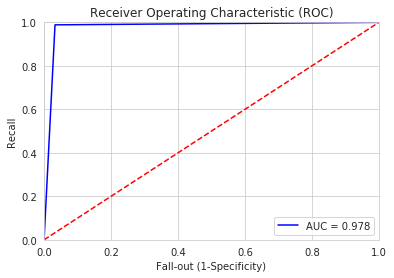

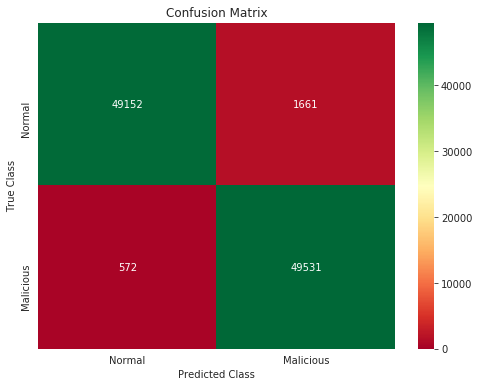

In [75]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2, './Figures/ROC_ann_2h_unisoftsigbinlosadam2_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam2_redds10bal.png')

In [76]:
ann_2h_unisoftsigbinlosadam3 = ann_2h(neurons=66,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 66)                2970      
_________________________________________________________________
dense_23 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_24 (Dense)             (None, 34)                1734      
_________________________________________________________________
batch_normalization_6 (Batch (None, 34)                136       
_________________________________________________________________
dropout_6 (Dropout)          (None, 34)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 35        
Total params: 8,225
Trainable params: 8,157
Non-trainable params: 68
_________________________________________________________________
None


In [77]:
hist_ann_2h_unisoftsigbinlosadam3 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam3_redds20bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam3,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 66)

Sun Jun  9 18:24:46 2019
Train on 258342 samples, validate on 64586 samples
Epoch 1/200
258342/258342 [==============================] - 16s 64us/step - loss: 0.2493 - acc: 0.8870 - val_loss: 0.1350 - val_acc: 0.9392
Epoch 2/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.1268 - acc: 0.9452 - val_loss: 0.0976 - val_acc: 0.9570
Epoch 3/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.1012 - acc: 0.9557 - val_loss: 0.0824 - val_acc: 0.9653
Epoch 4/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.0866 - acc: 0.9616 - val_loss: 0.0782 - val_acc: 0.9661
Epoch 5/200
258342/258342 [==============================] - 16s 60us/step - loss: 0.0757 - acc: 0.9667 - val_loss: 0.0765 - val_acc: 0.9678
Epoch 6/200
258342/258342 [==============================] - 15s 60us/step - loss: 0.0676 - acc: 0.9707 - val_loss: 0.0657 - val_acc: 0.9717
Epoch 7/200
258342/258342 [==============================] - 16s 60us/step - l

In [78]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.03006593302809917


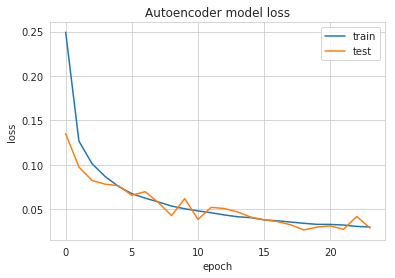

In [79]:
best_loss_value_ann_2h_unisoftsigbinlosadam3 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam3, './Figures/ann_2h_unisoftsigbinlosadam3.png')

In [131]:
pred_ann_2h_prob_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3 = ann_predict(ann_2h_unisoftsigbinlosadam3,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9873459114511078
              precision    recall  f1-score   support

           0     0.9870    0.9879    0.9874     50813
           1     0.9877    0.9868    0.9873     50103

   micro avg     0.9873    0.9873    0.9873    100916
   macro avg     0.9873    0.9873    0.9873    100916
weighted avg     0.9873    0.9873    0.9873    100916



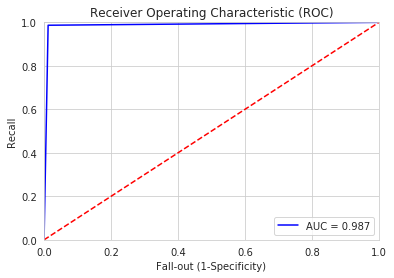

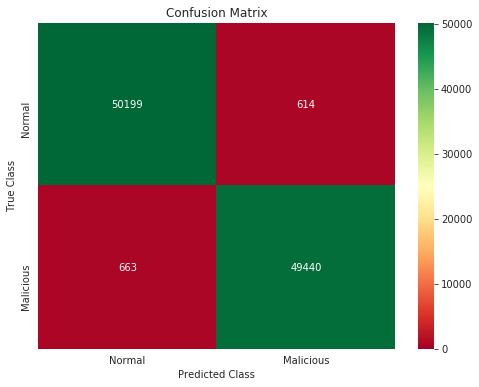

In [81]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3, './Figures/ROC_ann_2h_unisoftsigbinlosadam3_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam3_redds10bal.png')

#### >>>>>>>>>>>>>>>>>>>

In [82]:
ann_2h_unisoftsigbinlosadam4 = ann_2h(neurons=66,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 66)                2970      
_________________________________________________________________
dense_27 (Dense)             (None, 50)                3350      
_________________________________________________________________
dense_28 (Dense)             (None, 34)                1734      
_________________________________________________________________
batch_normalization_7 (Batch (None, 34)                136       
_________________________________________________________________
dropout_7 (Dropout)          (None, 34)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 35        
Total params: 8,225
Trainable params: 8,157
Non-trainable params: 68
_________________________________________________________________
None


In [83]:
hist_ann_2h_unisoftsigbinlosadam4 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam4_redds20bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam4,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 66)

Sun Jun  9 18:30:58 2019
Train on 258342 samples, validate on 64586 samples
Epoch 1/200
258342/258342 [==============================] - 17s 65us/step - loss: 0.2639 - acc: 0.8787 - val_loss: 0.1499 - val_acc: 0.9369
Epoch 2/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.1394 - acc: 0.9387 - val_loss: 0.1161 - val_acc: 0.9512
Epoch 3/200
258342/258342 [==============================] - 16s 62us/step - loss: 0.1118 - acc: 0.9500 - val_loss: 0.1043 - val_acc: 0.9551
Epoch 4/200
258342/258342 [==============================] - 16s 62us/step - loss: 0.0980 - acc: 0.9555 - val_loss: 0.0809 - val_acc: 0.9636
Epoch 5/200
258342/258342 [==============================] - 16s 62us/step - loss: 0.0879 - acc: 0.9605 - val_loss: 0.0667 - val_acc: 0.9700
Epoch 6/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.0797 - acc: 0.9643 - val_loss: 0.0839 - val_acc: 0.9631
Epoch 7/200
258342/258342 [==============================] - 16s 61us/step - l

In [84]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.03610239725743729


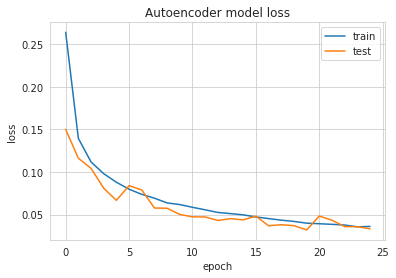

In [85]:
best_loss_value_ann_2h_unisoftsigbinlosadam4 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam4, './Figures/ann_2h_unisoftsigbinlosadam4.png')

In [86]:
pred_ann_2h_prob_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4 = ann_predict(ann_2h_unisoftsigbinlosadam4,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9852154266915059
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     50813
           1       0.98      0.99      0.99     50103

   micro avg       0.99      0.99      0.99    100916
   macro avg       0.99      0.99      0.99    100916
weighted avg       0.99      0.99      0.99    100916



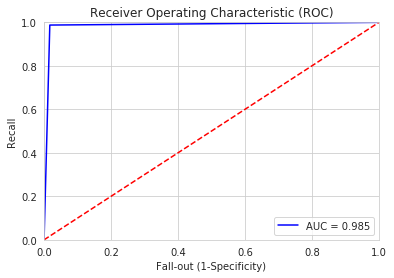

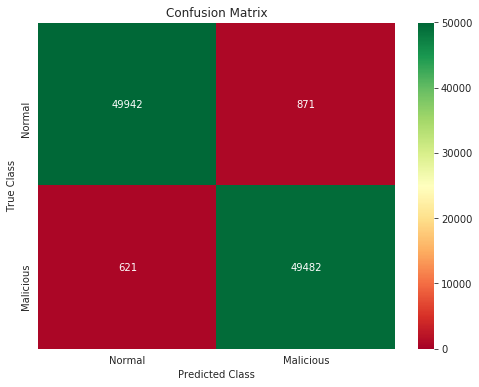

In [87]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4, './Figures/ROC_ann_2h_unisoftsigbinlosadam4_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam4_redds10bal.png')

In [114]:
ann_24n_unisoftsigbinlosadam = ann_1h_24n(neurons=66,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 66)                4422      
_________________________________________________________________
dense_47 (Dense)             (None, 50)                3350      
_________________________________________________________________
batch_normalization_8 (Batch (None, 50)                200       
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 51        
Total params: 8,023
Trainable params: 7,923
Non-trainable params: 100
_________________________________________________________________
None


In [115]:
hist_ann_24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_24n_unisoftsigbinlosadam_redds20bal.h5",
                                        ann = ann_24n_unisoftsigbinlosadam,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 66)

Sun Jun  9 18:59:03 2019
Train on 258342 samples, validate on 64586 samples
Epoch 1/200
258342/258342 [==============================] - 17s 66us/step - loss: 0.2193 - acc: 0.9044 - val_loss: 0.1344 - val_acc: 0.9420
Epoch 2/200
258342/258342 [==============================] - 16s 62us/step - loss: 0.1253 - acc: 0.9466 - val_loss: 0.1067 - val_acc: 0.9603
Epoch 3/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.0921 - acc: 0.9618 - val_loss: 0.0754 - val_acc: 0.9699
Epoch 4/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.0729 - acc: 0.9702 - val_loss: 0.0601 - val_acc: 0.9752
Epoch 5/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.0628 - acc: 0.9746 - val_loss: 0.0482 - val_acc: 0.9807
Epoch 6/200
258342/258342 [==============================] - 16s 61us/step - loss: 0.0551 - acc: 0.9776 - val_loss: 0.0554 - val_acc: 0.9788
Epoch 7/200
258342/258342 [==============================] - 16s 61us/step - l

Best loss value: 0.021915465629069406


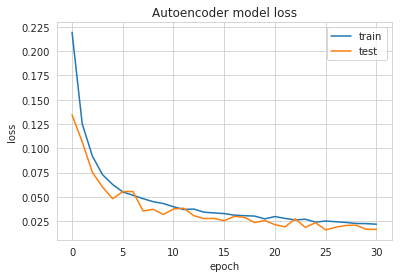

In [116]:
best_loss_value_ann_24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann_24n_unisoftsigbinlosadam, './Figures/ann_24_unisoftsigbinlosadam.png')

In [117]:
pred_ann_24n_prob_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam = ann_predict(ann_24n_unisoftsigbinlosadam,test_x)

Overall accuracy of Neural Network model: 0.9941139165246343
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     50813
           1       0.99      1.00      0.99     50103

   micro avg       0.99      0.99      0.99    100916
   macro avg       0.99      0.99      0.99    100916
weighted avg       0.99      0.99      0.99    100916



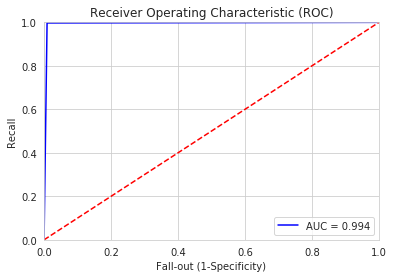

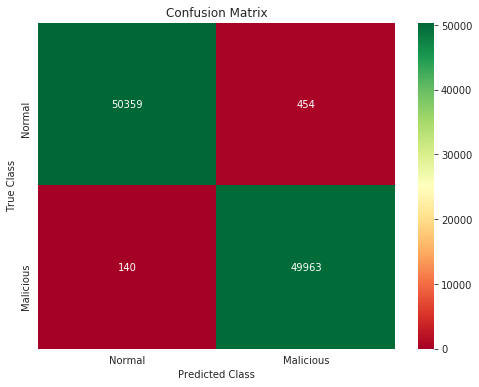

In [118]:
plot_roc_cm(pred_ann_24n_01_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam, './Figures/ROC_ann_24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_24n_unisoftsigbinlosadam_redds10bal.png')

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
#                              min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.3, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [121]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_asam, train_y)

pred_y_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_asam),
                              y=test_y,
                              cv=KFold(n_splits=5, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_RF,digits=4))

Sun Jun  9 19:06:51 2019
--- 2495.179598093033 seconds ---
              precision    recall  f1-score   support

           0     0.9963    0.9981    0.9972     50813
           1     0.9980    0.9962    0.9971     50103

   micro avg     0.9972    0.9972    0.9972    100916
   macro avg     0.9972    0.9971    0.9972    100916
weighted avg     0.9972    0.9972    0.9972    100916



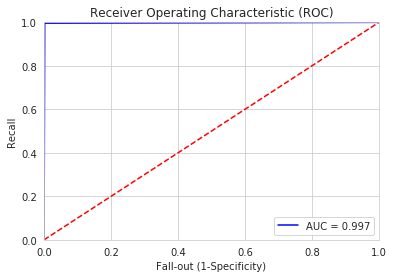

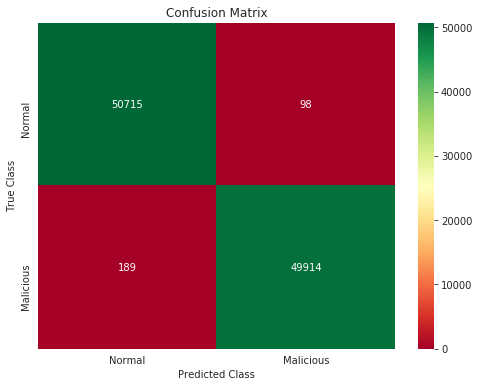

In [122]:
plot_roc_cm(pred_y_RF, pred_y_RF, './Figures/ROC_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png', './Figures/CM_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png')